# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [57]:

### Your code implementation goes here.
### Feel free to use as many code cells as needed.


In [119]:
""" Modules """

from __future__ import print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import struct
import sys
import tarfile
import gzip
import idx2numpy
import tensorflow as tf
import time
import glob
import h5py

#from IPython.display import display, Image
from scipy import ndimage
from scipy import misc
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from array import array as pyarray
from PIL import Image, ImageDraw

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Download the MNIST data set to local machine from links provided [here](http://yann.lecun.com/exdb/mnist/).

Contains a training set of 60,000 examples, and a test set of 10,000 handwritten digits that have been size-normalized and centered in a fixed-size image.

The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

In [120]:
""" Import the MNIST Data """
url = 'http://yann.lecun.com/exdb/mnist/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """
    A hook to report the progress of a download. 
    Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
    else:
        sys.stdout.write(".")
        sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if expected_bytes == None:
        print('Found', filename, 'but no size to verify against')
    elif statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [121]:
train_images_filename = maybe_download('train-images-idx3-ubyte.gz', 9912422)
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz', 28881)
test_images_filename  = maybe_download('t10k-images-idx3-ubyte.gz', 1648877)
test_labels_filename  = maybe_download('t10k-labels-idx1-ubyte.gz', 4542)

Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


Extract the dataset from the compressed .gz files.

In [122]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .gz
    # extract data
    if os.path.isfile(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        inF = gzip.GzipFile(filename, 'rb')
        s = inF.read()
        inF.close()

        outF = open(root, 'wb')
        outF.write(s)
        outF.close()
    # Return as numpy array
    f = open(root, 'rb')
    if 'images' in root:
        x = idx2numpy.convert_from_file(f)
        f.close()

    elif 'labels' in root:
        magic_nr, size = struct.unpack(">II", f.read(8))
        x = pyarray("b", f.read())
        f.close()

    return np.array(x)

train_images = maybe_extract(train_images_filename)
train_labels = maybe_extract(train_labels_filename)
test_images  = maybe_extract(test_images_filename)
test_labels  = maybe_extract(test_labels_filename)

print ("\nDimension check...")
print ("\t training labels:", train_labels.shape)
print ("\t training images:", train_images.shape)
print ("\t test set labels:", test_labels.shape)
print ("\t test set labels:", test_images.shape)

train-images-idx3-ubyte already present - Skipping extraction of train-images-idx3-ubyte.gz.
train-labels-idx1-ubyte already present - Skipping extraction of train-labels-idx1-ubyte.gz.
t10k-images-idx3-ubyte already present - Skipping extraction of t10k-images-idx3-ubyte.gz.
t10k-labels-idx1-ubyte already present - Skipping extraction of t10k-labels-idx1-ubyte.gz.

Dimension check...
	 training labels: (60000,)
	 training images: (60000, 28, 28)
	 test set labels: (10000,)
	 test set labels: (10000, 28, 28)


Examine a few images to make sure that it's sensible.

In [123]:
def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()

Image below should be a 5


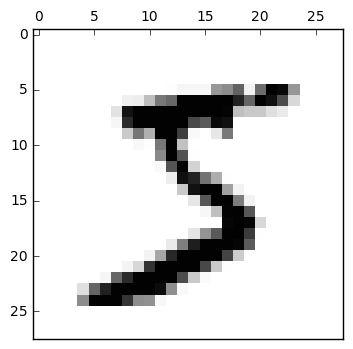

Image below should be a 0


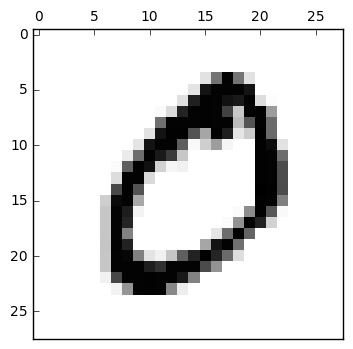

Image below should be a 4


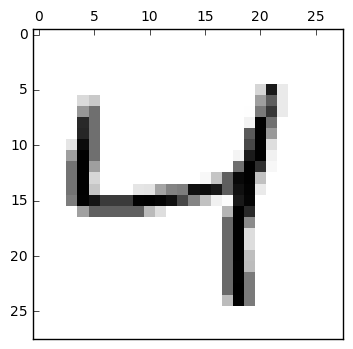

Image below should be a 1


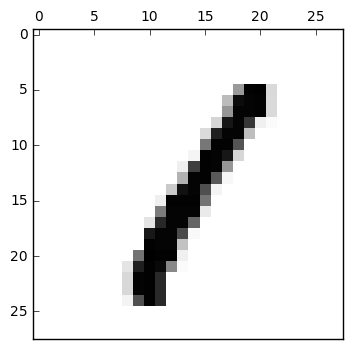

Image below should be a 9


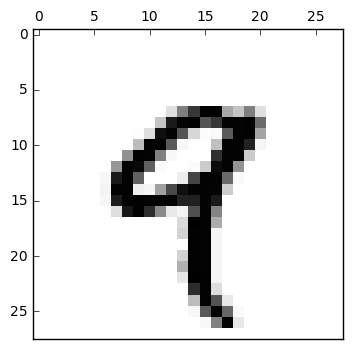

In [124]:
for i in xrange(5):
    print("Image below should be a", train_labels[i])
    show(train_images[i])

We also want to make sure that the image values are normalized (to suit to DNN).

Currently, the range of values are:

In [39]:
train_images.min(),train_images.max()

(0, 255)

We'll normalize them to a range of 0 to 1, which is suitable for hidden relu layers.

Aside, this is in contrast to activation functions like `tanh` are used, which would better suit a range of -.5 to .5

New min and max: 0.0 1.0


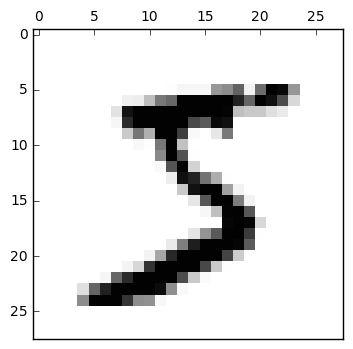

In [41]:
pixel_max = float(train_images.max())

train_images = train_images / pixel_max
test_images  = test_images / pixel_max

# Check images are still legit:
print("New min and max:", train_images.min(),train_images.max())

show(train_images[0])

We need to create synthetic combinations of these images. Eg., up to five images combined at a time.

This section will create training and test sets of these synthetic sequences.

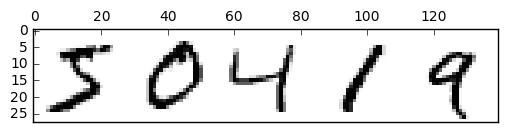

In [42]:
# Using numpy.hstack will stack together the pixel arrays to form synthetic sequences.
# Example:
show(np.hstack(train_images[:5]))

So we will need to create a random (ideally reproducible) set of these sequences up to length 5.

We also need to handle sequences of varying lengths.

The image below should show [ 4  4  5 -1 -1]


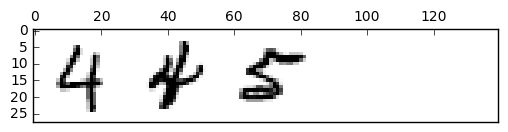

The image below should show [4 2 7 7 1]


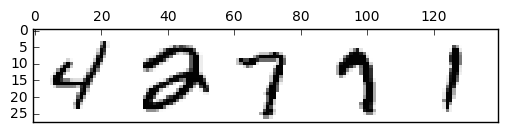

The image below should show [ 8 -1 -1 -1 -1]


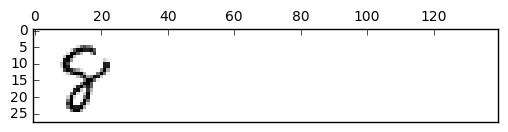

In [43]:
# Define maximum sequence length
seq_max_n = 5

# Define the number of training, validation, and test sequences to create
n_train_seq = 100000
n_valid_seq =  30000  # Note - these will come from test data
n_test_seq  =  30000

# Create max-length sequences as an array of references to single digits
np.random.seed(seed=345)
train_seq = np.random.randint(len(train_images), size=[n_train_seq, seq_max_n])
valid_seq = np.random.randint(len(test_images), size=[n_valid_seq, seq_max_n])
test_seq  = np.random.randint(len(test_images),  size=[n_test_seq, seq_max_n])

# Generate sequence lengths (1 - seq_max_n)
np.random.seed(seed=54)
train_seq_n = np.random.randint(seq_max_n, size=n_train_seq) + 1
valid_seq_n = np.random.randint(seq_max_n, size=n_valid_seq) + 1
test_seq_n  = np.random.randint(seq_max_n, size=n_test_seq) + 1

# Define a no-digit matrix of zeros and append as last item in image sets
# Label for this is -1
no_digit_array = [np.zeros(train_images[0].shape)]
train_images=np.append(train_images, no_digit_array, axis=0)
test_images=np.append(test_images, no_digit_array, axis=0)
train_labels=np.append(train_labels, -1)
test_labels=np.append(test_labels, -1)

# Reference 'no_digit' beyond allocated sequence length

''' Substitute in no-digit matrices beyond allocated sequence length '''
def no_digit_sub(seq, seq_n, seq_max_n = seq_max_n):
    if seq_n < seq_max_n:
        to_zero = range(seq_n, seq_max_n)
        for z in to_zero:
            # Nb, this -1 references last item in array
            # Not to be confused with -1 label above
            seq[z] = -1
    
for i, n in enumerate(train_seq_n):
    no_digit_sub(train_seq[i], n)
    
for i, n in enumerate(valid_seq_n):
    no_digit_sub(valid_seq[i], n)
    
for i, n in enumerate(test_seq_n):
    no_digit_sub(test_seq[i], n)

print ("The image below should show", train_labels[train_seq[0]])
show(np.hstack(train_images[train_seq[0]]))

print ("The image below should show", test_labels[valid_seq[0]])
show(np.hstack(test_images[valid_seq[0]]))

print ("The image below should show", test_labels[test_seq[0]])
show(np.hstack(test_images[test_seq[0]]))

Above, we created an array of length-5 arrays. Each length-5 array contains index references to single digits.

The images above are created by combining these references. However, we need to store these as single images to operate on.

Final image array shapes...
train	 (100000, 28, 140)
valid	 (30000, 28, 140)
test	 (30000, 28, 140)

The image below should show [ 4  4  5 -1 -1]


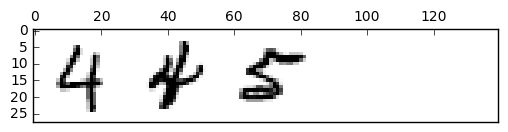

The image below should show [4 2 7 7 1]


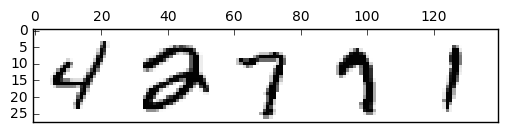

The image below should show [ 8 -1 -1 -1 -1]


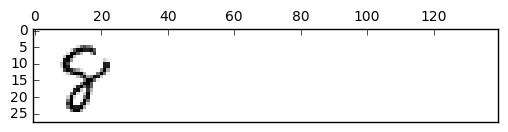

In [46]:
# Initialize final train, valid, and test sets of images:
train = np.empty(np.append(n_train_seq, np.hstack(train_images[train_seq[0]]).shape), dtype=float)
valid = np.empty(np.append(n_valid_seq, np.hstack(test_images[valid_seq[0]]).shape), dtype=float)
test  = np.empty(np.append(n_test_seq, np.hstack(test_images[test_seq[0]]).shape), dtype=float)

train_l = np.empty(np.append(n_train_seq, seq_max_n), dtype=int)
valid_l = np.empty(np.append(n_valid_seq, seq_max_n), dtype=int)
test_l  = np.empty(np.append(n_test_seq, seq_max_n), dtype=int)

print("Final image array shapes...")
print('train\t', train.shape)
print('valid\t', valid.shape)
print('test\t', test.shape)

# Fill in these arrays with stacked images
for i, s in enumerate(train_seq):
    train[i] = np.hstack(train_images[s])
    train_l[i] = train_labels[s]

for i, s in enumerate(valid_seq):
    valid[i] = np.hstack(test_images[s])
    valid_l[i] = test_labels[s]

for i, s in enumerate(test_seq):
    test[i] = np.hstack(test_images[s])
    test_l[i] = test_labels[s]

print()
# Tests...
print ("The image below should show", train_l[0])
show(train[0])

print ("The image below should show", valid_l[0])
show(valid[0])

print ("The image below should show", test_l[0])
show(test[0])

We now have to get data into shape suitable for convolution network...

In [47]:
img_height = train[0].shape[0]
img_width  = train[0].shape[1]
num_labels = 11  # -1 to 9
num_channels = 1 # grayscale

def reformat(dataset, labels):
    dataset = dataset.reshape(
        (-1, img_width, img_height, num_channels)).astype(np.float32)
    labels = ((np.arange(num_labels) - 1) == labels[:,:,None]).astype(np.float32)
    return dataset, labels

train, train_l = reformat(train, train_l)
valid, valid_l = reformat(valid, valid_l)
test, test_l   = reformat(test, test_l)
print('Training set', train.shape, train_l.shape)
print('Validation set', valid.shape, valid_l.shape)
print('Test set', test.shape, test_l.shape)

Training set (100000, 140, 28, 1) (100000, 5, 11)
Validation set (30000, 140, 28, 1) (30000, 5, 11)
Test set (30000, 140, 28, 1) (30000, 5, 11)


Notice in the above that the labels have been one-hot encoded as 2D vectors, which provide location on axis 0 and value information on axis 1.

For example...

In [48]:
print(train_l[0])  # Should correspond to 4,4,5 shown above (trailed by -1,-1)

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


We now have our images and labels in reasonable shape.

Time to implement our DNN. We'll start with convoluation layers feeding into 5 logit classifiers.

In [49]:
# Function to determine prediction accuracy
def accuracy(predictions, labels):
    return(100.0 * np.sum(np.argmax(predictions, 2) == np.argmax(labels, 2))
          / predictions.shape[0] / predictions.shape[1])

In [63]:
batch_size = 128
patch_size = 5

# Conv depths...
depth1 = 16
depth2 = 32
depth3 = 64

# Hidden depths...
n_hidden1 = 128
n_hidden2 = 64

graph = tf.Graph()

with graph.as_default():
    
    # Input data -----------------------
    tf_train = tf.placeholder(
        tf.float32, shape = (batch_size, img_width, img_height, num_channels)
    )
    tf_train_l = tf.placeholder(
        tf.float32, shape = (batch_size, svhn_max_digits, num_labels)
    )
    tf_valid = tf.constant(valid)
    tf_test  = tf.constant(test)
    
    # Net parameters -----------------------
    
    ## TODO: create wrapper function to initialize weights and biases
    
    # Convolution layers
    c1_w = tf.Variable(
        # truncated_normal good to avoid vanishing gradient; set stdev to something small (.05)
        # don't use 'random'
        # Deep Learning researcher - Yoshua Bengio
        # Tensorflow has Xavier initialization scheme to help optimize weight initialization
        # Supports quicker learning and avoid vanishing gradient
        # Contrib layers in tensorflow
        tf.truncated_normal([patch_size, patch_size, num_channels, depth1], stddev = 0.05)
    )
    c1_b = tf.Variable(
        tf.zeros([depth1])
    )
    c2_w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth1, depth2], stddev = 0.05)
    )
    c2_b = tf.Variable(
        tf.constant(1.0, shape = [depth2])
    )
    c3_w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, depth2, depth3], stddev = 0.05)
    )
    c3_b = tf.Variable(
        tf.constant(1.0, shape = [depth3])
    )
    # Fully connected layers
    f1_w = tf.Variable(
        tf.truncated_normal([depth3*3, n_hidden1], stddev = 0.05)
    )
    f1_b = tf.constant(1.0, shape = [n_hidden1])
    f2_w = tf.Variable(
        tf.truncated_normal([n_hidden1, n_hidden2], stddev = 0.05)
    )
    f2_b = tf.constant(1.0, shape = [n_hidden2])
    
    
    # Logistic classifier layers (one for each digit)
    s1_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s1_b = tf.constant(1.0, shape = [num_labels])
    s2_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s2_b = tf.constant(1.0, shape = [num_labels])
    s3_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s3_b = tf.constant(1.0, shape = [num_labels])
    s4_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s4_b = tf.constant(1.0, shape = [num_labels])
    s5_w = tf.Variable(tf.truncated_normal([n_hidden2, num_labels], stddev = 0.05))
    s5_b = tf.constant(1.0, shape = [num_labels])
    
    # Model ----------------------
    
    # Convolution wrapper
    # - Can move this (and others) to external python file with required libraries and import
    def conv2d(X, W, b):
        conv = tf.nn.conv2d(X, W, strides = [1, 2, 2, 1], padding = 'SAME') + b
        # Order (1) pool then (2) hidden reduces computation requirements and speeds learning
        pool = tf.nn.max_pool(conv, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        hidden = tf.nn.relu(pool)
        return hidden
    
    # Model
    def model(data, keep_prob = 1):
        # Convolution layers
        x = conv2d(data, c1_w, c1_b)
        x = conv2d(x,    c2_w, c2_b)
        x = conv2d(x,    c3_w, c3_b)
        
        # Fully connected
        shape = x.get_shape().as_list()  ## TODO: lookup tf.flatten to handle this MUCH faster (in C++)
        reshape = tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(reshape, f1_w) + f1_b)
        x = tf.nn.relu(tf.matmul(x, f2_w) + f2_b)
        x = tf.nn.dropout(x, keep_prob)
        
        # Logistic classifiers for each digit
        logit1 = tf.matmul(x, s1_w) + s1_b
        logit2 = tf.matmul(x, s2_w) + s2_b
        logit3 = tf.matmul(x, s3_w) + s3_b
        logit4 = tf.matmul(x, s4_w) + s4_b
        logit5 = tf.matmul(x, s5_w) + s5_b
        
        # Combine predictions to match 2D encoding
        # Note. if using sparse_... need pack([]), but not `axis=1`
        pred = tf.pack([logit1, logit2, logit3, logit4, logit5], axis=1)
        print(pred)
        return(pred)

    # Run --------------------------
    # If model seems to be overfitting, look at:
    # l1 and l2 regularisers; batch normalization
    
    logits = model(tf_train, 0.50)  # Drop out - .75 too high. Try not to exceed .50
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 0, :], tf_train_l[:, 0])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 1, :], tf_train_l[:, 1])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 2, :], tf_train_l[:, 2])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 3, :], tf_train_l[:, 3])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 4, :], tf_train_l[:, 4]))
    
    ## TODO: examine Adam optimizer (has a self adjusting learning rate)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    train_pred = tf.nn.softmax(logits)
    valid_pred = tf.nn.softmax(model(tf_valid))
    test_pred  = tf.nn.softmax(model(tf_test))

Tensor("pack:0", shape=(128, 5, 11), dtype=float32)
Tensor("pack_1:0", shape=(30000, 5, 11), dtype=float32)
Tensor("pack_2:0", shape=(30000, 5, 11), dtype=float32)


In [79]:
""" Run the graph """
num_steps = 1000001
start_time = time.time()

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Intialized\n")
    
    for step in range(num_steps):
        offset  = (step * batch_size) % (train_l.shape[0] - batch_size)
        batch   = train[offset:(offset + batch_size), :, :, :]
        batch_l = train_l[offset:(offset + batch_size), :]
        feed_dict = {
            tf_train   : batch,
            tf_train_l : batch_l
        }
        _, l, predictions = session.run(
            [optimizer, loss, train_pred], feed_dict = feed_dict
        )
        
        if (step % 1000 == 0):
            print('--- Step %d ---' % (step))
            print('Time elapsed: %.1f seconds' % (time.time() - start_time))
            print('Minibatch loss: %f' % (l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_l))
            print('Validation accuracy: %.1f%%' % accuracy(valid_pred.eval(), valid_l))
            print()
    
    print('--- Test ---')
    print('Test accuracy: %.1f%%' % accuracy(test_pred.eval(), test_l))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Intialized

--- Step 0 ---
Time elapsed: 4.4 seconds
Minibatch loss: 13.666569
Minibatch accuracy: 6.7%
Validation accuracy: 6.1%

--- Step 1000 ---
Time elapsed: 120.6 seconds
Minibatch loss: 6.869938
Minibatch accuracy: 51.2%
Validation accuracy: 50.3%

--- Step 2000 ---
Time elapsed: 231.2 seconds
Minibatch loss: 6.398312
Minibatch accuracy: 55.6%
Validation accuracy: 54.5%

--- Step 3000 ---
Time elapsed: 340.6 seconds
Minibatch loss: 6.349179
Minibatch accuracy: 51.6%
Validation accuracy: 57.5%

--- Step 4000 ---
Time elapsed: 450.8 seconds
Minibatch loss: 6.066477
Minibatch accuracy: 57.2%
Validation accuracy: 59.1%

--- Step 5000 ---
Time elapsed: 561.2 seconds
Minibatch loss: 5.937634
Minibatch accuracy: 55.5%
Validation accuracy: 60.3%

--- Step 6000 ---
Time elapsed: 670.1 seconds
Minibatch loss: 5.629911
Minibatch accuracy: 59.8%
Validation accuracy: 61.3%

--- Step 7000 ---
Time elapsed: 779.3 seconds

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

I knew I wanted to use a convolution neural net, because convolutions are well suited to detecting objects in images. This will become especially important in the subsequent portions of this project, where the numbers can appear in any part of the image, at any angle/rotation, etc.

My final convolution architecture (described in following section) was based on previously successful designs. To quickly summarise, the convolution layers increase the input depth, enabling detection of objects across the image, and then fully connected layers handle the learning.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

My final architecture involves convoluations and fully connected layers. It can be summarised as:

- 3 x convolution layers with max pooling and relu activation; depth increases with each additional layer.
- 2 x fully connected layers with relu activation; relu numbers decrease with each additional layer.
- Drop out is applied.
- 5 x ordered logistic classifiers trained on five ordered input labels.


### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

Training was achieved using stochastic gradient descent: training on small, random samples of the data. Loss was summed across the five logistic classifiers.

The samples used for training came from a synthetic dataset of images including one to five numbers, that was constructed using the MNIST dataset. Images in the synthetic datatset were constructed as follows:

- Randomly sample five images from MNIST (five being the maximum allowable sequence length).
- Randomly sample a sequence length of 1 to 5.
- For sequence lengths `n` that were less than 5, replace the last `5 - n` images with blank regions and label them `-1`.

This process was done to create 100000 sequences for training data, and 30000 for validation and 30000 for test data.

Many examples are shown above. Here is another:

The image below should show [ 0  0  7  9 -1]


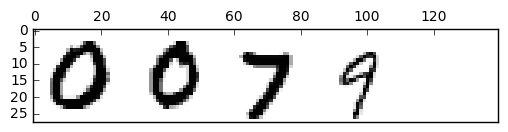

In [82]:
print ("The image below should show", train_labels[train_seq[100]])
show(np.hstack(train_images[train_seq[100]]))

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



Importing the Street View House Numbers (SVNH) datasets...

In [5]:
""" Import the SVNH Data """
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

train_svnh_filename = maybe_download('train.tar.gz', None)
test_svnh_filename  = maybe_download('test.tar.gz', None)

Found train.tar.gz but no size to verify against
Found test.tar.gz but no size to verify against


In [6]:
def maybe_extract_svnh(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    # extract data
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
        
    return root

train_svnh_folder = maybe_extract_svnh(train_svnh_filename)
test_svnh_folder = maybe_extract_svnh(test_svnh_filename)    

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


The downloaded datasets are stored in two folders. Each folder contains the relevant .png files and a digitStruct.mat file containing labels and bounding box information. We'll convert these to useable numpy arrays...

In [10]:
'''
SUPPORT FUNCTIONS
Ref: https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657
'''

# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s
# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

def digitStructMatAsList(directory):
    fin = os.path.join(directory, 'digitStruct.mat')
    dsf = DigitStructFile(fin)
    return dsf.getAllDigitStructure_ByDigit()

In [11]:
# Get all .mat file information into lists
# - Takes some time
train_svhn_data = digitStructMatAsList(train_svnh_folder)
test_svhn_data  = digitStructMatAsList(test_svnh_folder)

In [12]:
""" Data check """
print('Example filename\n\t', train_svhn_data[0]['filename'])
eg_box = train_svhn_data[0]['boxes']
print('Example box information with', len(eg_box), 'digits\n\t', eg_box)

Example filename
	 1.png
Example box information with 2 digits
	 [{'width': 81.0, 'top': 77.0, 'label': 1.0, 'left': 246.0, 'height': 219.0}, {'width': 96.0, 'top': 81.0, 'label': 9.0, 'left': 323.0, 'height': 219.0}]


We'll now go ahead and form images for training and testing based on method used by [Goodfellow et al., (2013)]( https://arxiv.org/pdf/1312.6082.pdf):

*"We preprocess the dataset in the following way – first we find the small rectangular bounding box
that will contain individual character bounding boxes. We then expand this bounding box by 30%
in both the x and the y direction, crop the image to that bounding box and resize the crop to 64 × 64
pixels. We then crop a 54 × 54 pixel image from a random location within the 64 × 64 pixel image."*

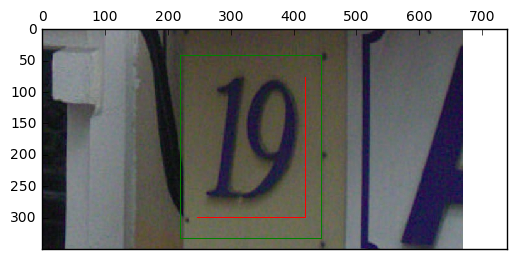

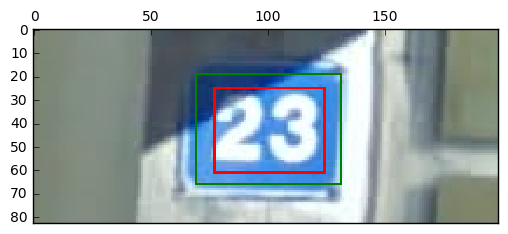

In [13]:
# Step 1: identifying bounding boxes
# Given a list of JSON boxes, find stuiable box area
def get_box(boxes):
    # Gather all bounding info for each box
    x0, y0, x1, y1 = [],[],[],[]
    for i in boxes:
        x0.append(i['left'])
        y0.append(i['top'])
        x1.append(i['left'] + i['width'])
        y1.append(i['top'] + i['height'])
    
    # Get best box that covers all images
    min_x0 = np.min(x0)
    min_y0 = np.min(y0)
    max_x1 = np.max(x1)
    max_y1 = np.max(y1)
    
    # Return coordinates as x0,y0,x1,y1
    return [min_x0, min_y0, max_x1, max_y1]

# Expand region of a bounding box by certain amount
# Take and return corner coordinates 
# coords = [x0, y0, x1, y1]
def expand_box(coords, amount = 0.3):
    x_margin = amount * (coords[2] - coords[0]) / 2
    y_margin = amount * (coords[3] - coords[1]) / 2
    
    return [coords[0] - x_margin, coords[1] - y_margin,
            coords[2] + x_margin, coords[3] + y_margin]

for i in xrange(2):
    original_box = get_box(train_svhn_data[i]['boxes'])
    expanded_box = expand_box(original_box)

    im = Image.open('train/' + train_svhn_data[i]['filename'])
    
    draw = ImageDraw.Draw(im)
    draw.rectangle(original_box, outline = 'red')
    draw.rectangle(expanded_box, outline = 'green')
    del draw

    show(im)

For each image, we'll compute the expanded bounding region (shown as green above), convert to a 64 x 64 grayscale image (graysacale suggested by many as a suitable approach), and then take a random 54 x 54 segment to create an offset.

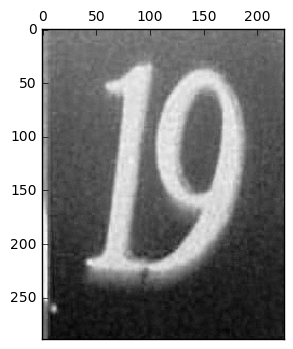

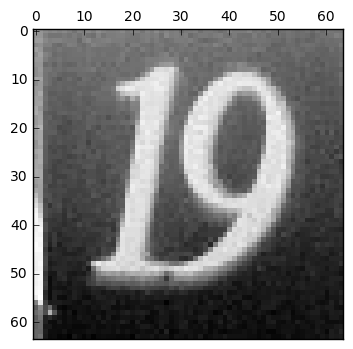

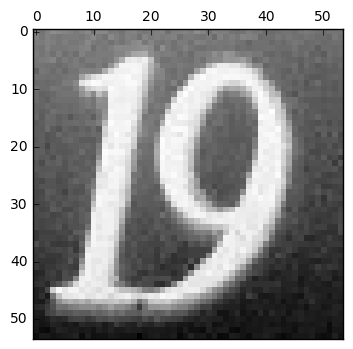

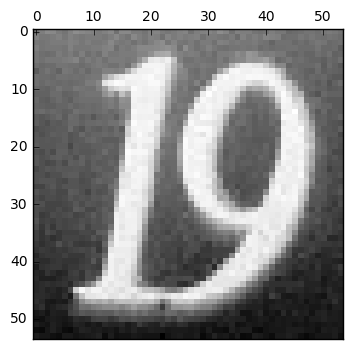

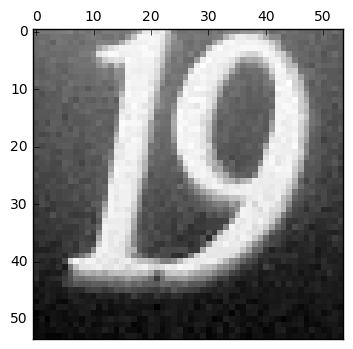

In [16]:
# Extra Helper Functions...

# Import an image as grayscale and crop it's expanded box
def crop_expanded_box(file, boxes):
    im = Image.open(file).convert('L')
    original_box = get_box(boxes)
    expanded_box = expand_box(original_box)
    im = im.crop(expanded_box)
    return im

def find_coeffs(pa, pb):
    matrix = []
    for p1, p2 in zip(pa, pb):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = np.matrix(matrix, dtype=np.float)
    B = np.array(pb).reshape(8)

    res = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.array(res).reshape(8)

def resize_image(img, new_width = 64, new_height = 64):
    width, height = img.size
    
    coeffs = find_coeffs(
        [(0, 0), (new_width, 0), (new_width, new_height), (0, new_height)],
        [(0, 0), (width, 0), (width, height), (0, height)])
    
    new_img = img.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    return(new_img)
    
#a = crop_expanded_box('train/' + train_svhn_data[0]['filename'], train_svhn_data[0]['boxes'])
#show(resize_image(a))

def random_crop(img, crop_width = 54, crop_height = 54):
    width, height = img.size
    
    if (width < crop_width | height < crop_height):
        print('Image dimensions are too small to crop. Returning image.')
        return(img)
    
    x_offset = np.random.randint(0, width - crop_width)
    y_offset = np.random.randint(0, height - crop_height)
    
    crop_box = [x_offset, y_offset,
                x_offset + crop_width,
                y_offset + crop_height]
    
    img = img.crop(crop_box)
    return img

# Wrapper function for all
def data_to_thumbnail(svhn_data, file_directory):
    img = crop_expanded_box(os.path.join(file_directory, svhn_data['filename']), svhn_data['boxes'])
    img = resize_image(img)
    img = random_crop(img)
    return(img)

# Examples
a = crop_expanded_box('train/' + train_svhn_data[0]['filename'], train_svhn_data[0]['boxes'])
show(a)
a = resize_image(a)
show(a)
b = random_crop(a)
show(b)
c = random_crop(a)
show(c)
del(a, b, c)


show(data_to_thumbnail(train_svhn_data[0], 'train/'))

In [12]:
def create_thumbnail(svhn_data, directory):
    img = data_to_thumbnail(svhn_data, directory)
    file_name, ext = os.path.splitext(svhn_data['filename'])
    new_file_name = file_name + ".thumbnail"
    img.save(os.path.join(directory, new_file_name), "PNG")

print('Creating thumbnails of training images...')
for dat in train_svhn_data:
    create_thumbnail(dat, train_svnh_folder)
print('Thumbnails created.')
    
print('Creating thumbnails of test images...')
for dat in test_svhn_data:
    create_thumbnail(dat, test_svnh_folder)
print('Thumbnails created.')

Creating thumbnails of training images...
Thumbnails created.
Creating thumbnails of test images...
Thumbnails created.


Next we'll import these new thumbnails as numpy arrays with one-hot encoded labels

In [13]:
def list_2_nparrays(directory, svhn_data_list, max_digits = 5):
    labels = []
    png = []
    for img in svhn_data_list:
        labs = []
        for b in img['boxes']:
            labs.append(b['label'])
        
        # Check that length is appropriate, and skip if not
        if (len(labs) > max_digits):
            print(img['filename'])
            continue

        # Pad to full sequence length if necessary
        if(len(labs) < max_digits):
            labs = np.pad(labs, (0, max_digits - len(labs)), 'constant', constant_values=(-1))
        labels.append(labs)
        
        png.append(misc.imread(os.path.join(directory, img['filename'].split('.')[0] + '.thumbnail')))
    
    return (np.asarray(png), np.asarray(labels))

print('Any images with an invalid number of labels are listed here, and discarded from data...')
train_svhn_images, train_svhn_labels = list_2_nparrays(train_svnh_folder, train_svhn_data)
test_svhn_images,  test_svhn_labels  = list_2_nparrays(test_svnh_folder,  test_svhn_data)

# Convert label `10` to `0`
train_svhn_labels[train_svhn_labels == 10] = 0
test_svhn_labels[test_svhn_labels == 10] = 0

Any images with an invalid number of labels are listed here, and discarded from data...
29930.png


Note above that one image in the training data had six digits. It was possible to either keep this in and train for six digits, or remove it. Given that it is a major outlier among so many images, the choice was to remove it.

In [14]:
# Normalizing data...
pixel_max = float(train_svhn_images.max())

print("Original min and max:", train_svhn_images.min(), pixel_max)

train_svhn_images = train_svhn_images / pixel_max
test_svhn_images  = test_svhn_images  / pixel_max

# Check images are still legit:
print("New min and max:", train_svhn_images.min(), train_svhn_images.max())

Original min and max: 0 255.0
New min and max: 0.0 1.0


Shape of training images and labels:	 (33401, 54, 54) (33401, 5)
Shape of test images and labels:	 (13068, 54, 54) (13068, 5)

Should see [ 1.  9. -1. -1. -1.]


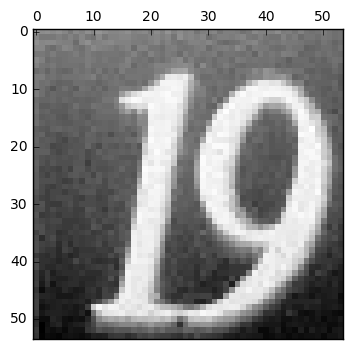

Should see [ 5. -1. -1. -1. -1.]


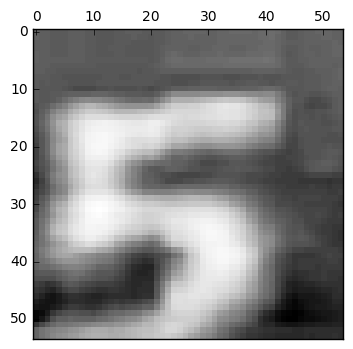

Should see [ 2.  3. -1. -1. -1.]


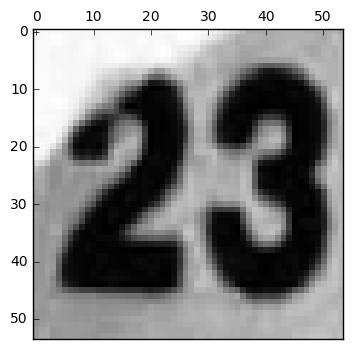

Should see [ 2.  1.  0. -1. -1.]


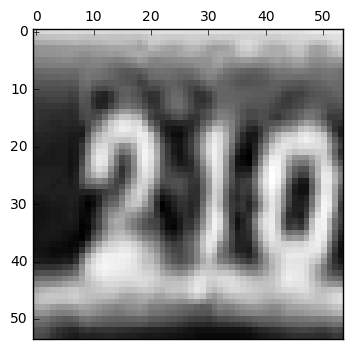

In [51]:
''' Data check '''
# Examine shapes and images
print('Shape of training images and labels:\t',
      train_svhn_images.shape, train_svhn_labels.shape)
print('Shape of test images and labels:\t',
      test_svhn_images.shape, test_svhn_labels.shape)

print()
for i in xrange(2):
    print('Should see', train_svhn_labels[i])
    show(train_svhn_images[i])
    
    print('Should see', test_svhn_labels[i])
    show(test_svhn_images[i])

Now we proceed to creating final train, validation, and test sets in appropriate format.

In [15]:
num_labels = 11  # -1 to 9
num_channels = 1 # grayscale
p_valid = 0.4    # Proportion of test set to be used for validation set

def reformat(dataset, labels):
    shp = dataset.shape
    dataset = dataset.reshape(
        (-1, shp[1], shp[2], num_channels)).astype(np.float32)
    labels = ((np.arange(num_labels) - 1) == labels[:,:,None]).astype(np.float32)
    return dataset, labels

n_valid = int(test_svhn_labels.shape[0] * p_valid)

train_svhn, train_svhn_l = reformat(train_svhn_images, train_svhn_labels)
valid_svhn, valid_svhn_l = reformat(test_svhn_images[:n_valid], test_svhn_labels[:n_valid])
test_svhn, test_svhn_l   = reformat(test_svhn_images[n_valid:], test_svhn_labels[n_valid:])

print('Training set', train_svhn.shape, train_svhn_l.shape)
print('Validation set', valid_svhn.shape, valid_svhn_l.shape)
print('Test set', test_svhn.shape, test_svhn_l.shape)

Training set (33401, 54, 54, 1) (33401, 5, 11)
Validation set (5227, 54, 54, 1) (5227, 5, 11)
Test set (7841, 54, 54, 1) (7841, 5, 11)


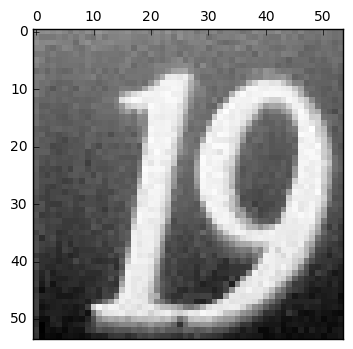

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


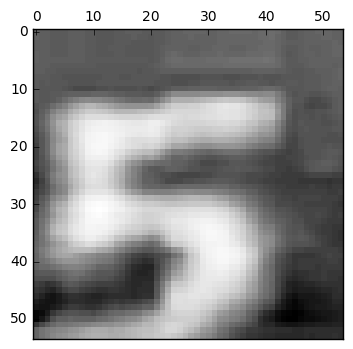

[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


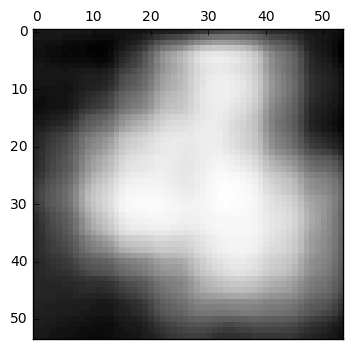

[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [57]:
# Checking one-hot encoding
show(np.squeeze(train_svhn, axis=(3,))[0])
print(train_svhn_l[0])

show(np.squeeze(valid_svhn, axis=(3,))[0])
print(valid_svhn_l[0])

show(np.squeeze(test_svhn, axis=(3,))[0])
print(test_svhn_l[0])

## We're now ready to train our model!

In [16]:
# Function to determine prediction accuracy
def accuracy(predictions, labels):
    return(100.0 * np.sum(np.argmax(predictions, 2) == np.argmax(labels, 2))
          / predictions.shape[0] / predictions.shape[1])

In [196]:
batch_size = 128
patch_size = 5
img_size = train_svhn.shape[1:3]
svhn_max_digits = train_svhn_l.shape[1]

# Conv depths...
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128

# Hidden layers...
n_hidden1 = 128
n_hidden2 = 3072
n_hidden3 = 3072

graph = tf.Graph()

with graph.as_default():
    
    # Input data -----------------------
    tf_train = tf.placeholder(
        tf.float32, shape = (batch_size, img_size[0], img_size[1], num_channels)
    )
    tf_train_l = tf.placeholder(
        tf.float32, shape = (batch_size, svhn_max_digits, num_labels)
    )
    tf_valid = tf.constant(valid_svhn)
    tf_test  = tf.constant(test_svhn)
    
    # Net parameters -----------------------
    
    # Wrapper functions for weights and biases of
    # convulations, fully connected, and linear predictor layers
    def conv_w_and_b(input, output):
        w = tf.Variable(
            tf.truncated_normal([patch_size, patch_size, input, output], stddev = 0.05)
        )
        b = tf.Variable(
            tf.zeros([output])
        )
        return w,b
    
    def fully_w_and_b(input, output):
        w = tf.Variable(
            tf.truncated_normal([input, output], stddev = 0.05)
        )
        b = tf.constant(1.0, shape = [output])
        
        return w,b
    
    def logit_w_and_b(input, output):
        w = tf.Variable(
            tf.truncated_normal([input, output], stddev = 0.05)
        )
        b = tf.constant(1.0, shape = [output])
        
        return w,b
    
    # Convolution layers
    c1_w, c1_b = conv_w_and_b(num_channels, depth1)
    c2_w, c2_b = conv_w_and_b(depth1, depth2)
    c3_w, c3_b = conv_w_and_b(depth2, depth3)
    c4_w, c4_b = conv_w_and_b(depth3, depth4)
    
    # Fully connected layers 
    f1_w, f1_b = fully_w_and_b(depth4, n_hidden1)
    f2_w, f2_b = fully_w_and_b(n_hidden1, n_hidden2)
    f3_w, f3_b = fully_w_and_b(n_hidden2, n_hidden3)
    
    # Linear predictors (one for each coordinate)
    s1_w, s1_b = logit_w_and_b(n_hidden3, num_labels)
    s2_w, s2_b = logit_w_and_b(n_hidden3, num_labels)
    s3_w, s3_b = logit_w_and_b(n_hidden3, num_labels)
    s4_w, s4_b = logit_w_and_b(n_hidden3, num_labels)
    s5_w, s5_b = logit_w_and_b(n_hidden3, num_labels)
    
    # Model ----------------------
    
    # Convolution wrapper
    def conv2d(X, W, b):
        conv = tf.nn.conv2d(X, W, strides = [1, 2, 2, 1], padding = 'SAME') + b
        # Order (1) pool then (2) hidden reduces computation requirements and speeds learning
        pool = tf.nn.max_pool(conv, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
        hidden = tf.nn.relu(pool)
        return hidden
    
    # Model
    def model(data, keep_prob = 1):
        # Convolution layers
        x = conv2d(data, c1_w, c1_b)
        x = conv2d(x,    c2_w, c2_b)
        x = conv2d(x,    c3_w, c3_b)
        x = conv2d(x,    c4_w, c4_b)
        
        # Fully connected
        shape = x.get_shape().as_list()
        reshape = tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(reshape, f1_w) + f1_b)
        x = tf.nn.relu(tf.matmul(x, f2_w) + f2_b)
        x = tf.nn.relu(tf.matmul(x, f3_w) + f3_b)
        x = tf.nn.dropout(x, keep_prob)
        
        # Logistic classifiers for each digit
        logit1 = tf.matmul(x, s1_w) + s1_b
        logit2 = tf.matmul(x, s2_w) + s2_b
        logit3 = tf.matmul(x, s3_w) + s3_b
        logit4 = tf.matmul(x, s4_w) + s4_b
        logit5 = tf.matmul(x, s5_w) + s5_b
        
        # Combine predictions to match 2D encoding
        # Note. if using sparse_... need pack([]), but not `axis=1`
        pred = tf.pack([logit1, logit2, logit3, logit4, logit5], axis=1)
        print(pred)
        return(pred)

    # Run --------------------------
    # If model seems to be overfitting, look at:
    # l1 and l2 regularisers; batch normalization
    
    logits = model(tf_train, 0.50)  # Try not to exceed .50
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 0, :], tf_train_l[:, 0])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 1, :], tf_train_l[:, 1])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 2, :], tf_train_l[:, 2])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 3, :], tf_train_l[:, 3])) +\
        tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits[:, 4, :], tf_train_l[:, 4]))
    
    # Adam optimizer (has a self adjusting learning rate)
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    train_pred = tf.nn.softmax(logits)
    valid_pred = tf.nn.softmax(model(tf_valid))
    test_pred  = tf.nn.softmax(model(tf_test))

Tensor("pack:0", shape=(128, 5, 11), dtype=float32)
Tensor("pack_1:0", shape=(5227, 5, 11), dtype=float32)
Tensor("pack_2:0", shape=(7841, 5, 11), dtype=float32)


In [77]:
""" Run the graph """
num_steps = 200001
start_time = time.time()
saver_directory = 'tf_saver'

if not os.path.exists(saver_directory):
    os.makedirs(saver_directory)

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    print("Intialized\n")
    
    # Create a saver.
    saver = tf.train.Saver()
    
    for step in range(num_steps):
        offset  = (step * batch_size) % (train_svhn_l.shape[0] - batch_size)
        batch   = train_svhn[offset:(offset + batch_size), :, :, :]
        batch_l = train_svhn_l[offset:(offset + batch_size), :]
        feed_dict = {
            tf_train   : batch,
            tf_train_l : batch_l
        }
        _, l, predictions = session.run(
            [optimizer, loss, train_pred], feed_dict = feed_dict
        )
        
        if (step % 1000 == 0):
            print('--- Step %d ---' % (step))
            print('Time elapsed: %.1f seconds' % (time.time() - start_time))
            print('Minibatch loss: %f' % (l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_l))
            print('Validation accuracy: %.1f%%' % accuracy(valid_pred.eval(), valid_svhn_l))
            print()
    
    # Save the model
    saver.save(session, saver_directory + '/model')
    
    print('--- Test ---')
    print('Test accuracy: %.1f%%' % accuracy(test_pred.eval(), test_svhn_l))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Intialized

--- Step 0 ---
Time elapsed: 3.4 seconds
Minibatch loss: 74.637222
Minibatch accuracy: 7.3%
Validation accuracy: 66.0%

--- Step 1000 ---
Time elapsed: 293.7 seconds
Minibatch loss: 6.122004
Minibatch accuracy: 60.2%
Validation accuracy: 67.2%

--- Step 2000 ---
Time elapsed: 579.8 seconds
Minibatch loss: 5.563206
Minibatch accuracy: 62.0%
Validation accuracy: 67.3%

--- Step 3000 ---
Time elapsed: 866.1 seconds
Minibatch loss: 5.221853
Minibatch accuracy: 64.5%
Validation accuracy: 68.1%

--- Step 4000 ---
Time elapsed: 1152.6 seconds
Minibatch loss: 5.230657
Minibatch accuracy: 63.0%
Validation accuracy: 68.3%

--- Step 5000 ---
Time elapsed: 1439.0 seconds
Minibatch loss: 5.153427
Minibatch accuracy: 65.0%
Validation accuracy: 68.0%

--- Step 6000 ---
Time elapsed: 1725.4 seconds
Minibatch loss: 5.455615
Minibatch accuracy: 62.8%
Validation accuracy: 68.6%

--- Step 7000 ---
Time elapsed: 2011.9 se

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

I converted all images to grayscale and resized them to a 64 x 64 pixel image.

The model performance is not great, but reasonable given my constraints. For example, the final test accuracy of 83% is noticeably poorer than the 97.84% reported by Goodfellow et al., (2013; https://arxiv.org/pdf/1312.6082.pdf). However, here, the model was run on a basic home desktop for ~16 hours, compared to the model by Goodfellow et al., which was run for "six days using 10 replicas in DistBelief".

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

Most changes were made in the preprocessing stage, and I went through a number of various approaches including

1. Resizing all images to 64 x 64 grayscale.
2. Boosting the number of 4 or 5-digit images by creating many distorted versions of the existing images.
3. Mixing the training and test data into new trianing and test sets due to differences in pixel distributions.
4. Following the approach of Goodfellow et al., by using the boundary boxes of images to create 54 x 54 pxiel grayscale images with the digits offset from centre.

For all, converting to grayscale and resizing to a smaller image helped reduce time (which was an important factor given the model was run on a home computer).

The images generated with approach 1 were simply too distorted and difficult to learn from. They led to large overfitting problems on the training data. The images in approach 2 were even more distorted, and led to practically no learning at all. For approach 3, this led to learning and generalization, but was still poor. My GitHub commits can be examined for these previous implementations. Approach 3 provided the model with reasonable training data and led to the best results.

Regarding the DNN model, my first approach was very similar to the simple model used for the MNIST in the first part of this project. Three convolution layers and two fully connected layers with a very small number of hidden nodes. This didn't perform well. With the exception of strange overfitting, learning accuracy never went much beyond 72% accuracy, and this was even after many hours of training.

Instead, I leaned towards the model dsdcribed by Goodfellow et al. (2013). My model was kept smaller, however, due to computing and time constriants. So the final model with four convolution layers and three hidden layers with many hidden nodes (3072) was far superior.

Overall, by making the training data cleaner and making the DNN deeper, the results improved dramatically.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

My very first model had a test accuracy of about 60%. A model with a second dropout achieved 71.4% with 1000001 iterations. A third model achieved test accuracy of 68.4% with half as many iterations. The final model reported about achieved an accuracy on the test set of 83% in far fewer iterations again (though similar time taken for training due to increase in complexity).

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



First step is to do all of the necessary preprocessing:

In [88]:
# Save grayscale thumbnail versions of the images:
for infile in glob.glob("self/*.jpg"):
    file, ext = os.path.splitext(infile)
    im = Image.open(infile).convert('L')
    
    width, height = im.size
    new_width, new_height = size[0], size[1]
    
    coeffs = find_coeffs(
        [(0, 0), (new_width, 0), (new_width, new_height), (0, new_height)],
        [(0, 0), (width, 0), (width, height), (0, height)])
    
    new_im = im.transform((new_width, new_height), Image.PERSPECTIVE, coeffs, Image.BICUBIC)
    new_im.save(file + ".thumbnail", "JPEG")

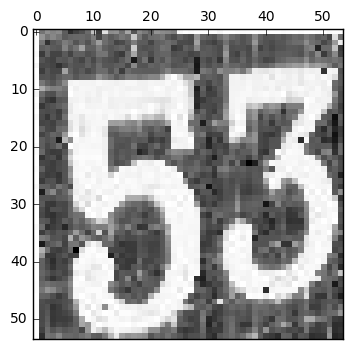

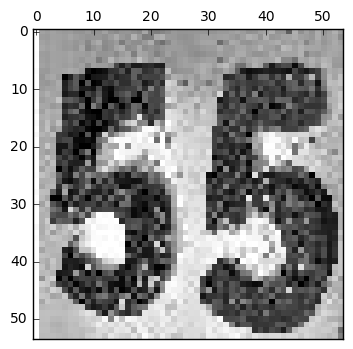

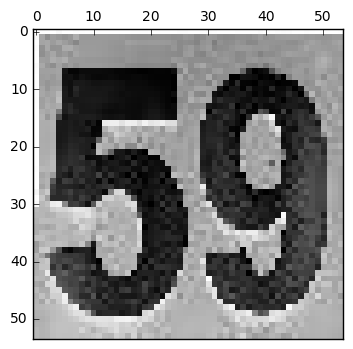

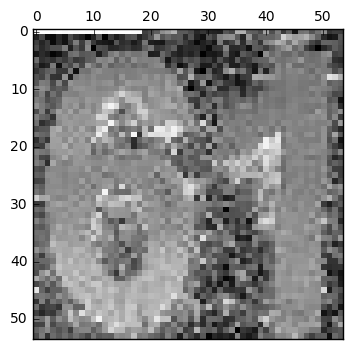

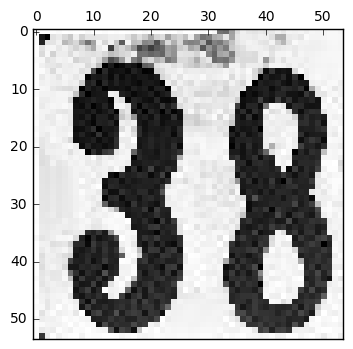

In [89]:
# Check images:
for infile in glob.glob("self/*.thumbnail"):
    show(Image.open(infile))

In [34]:
# Get the files into a suitable numpy array
self_images = []
for infile in glob.glob("self/*.thumbnail"):
    im = Image.open(infile)
    self_images.append(misc.imread(infile))

self_images = np.asarray(self_images)

# Normalize values
self_images = self_images / pixel_max

# Get into right shape
self_images = self_images.reshape(
        (-1, size[0], size[1], num_channels)).astype(np.float32)

print('Dimensions:', self_images.shape)

Dimensions: (5, 54, 54, 1)


In [91]:
with tf.Session(graph = graph) as sess:
    # Restore saved model
    new_saver = tf.train.import_meta_graph(saver_directory + '/model.meta')
    new_saver.restore(sess, saver_directory + '/model')
    
    # Test set (just match the validation set size)
    # At end just look at first few images
    to_test_with = np.concatenate((self_images, valid_svhn))[:(-self_images.shape[0])]

    feed_dict = {tf_valid: to_test_with}
    classification = valid_pred.eval(feed_dict, session=sess)

Predicition: [ 5  3 -1 -1 -1]


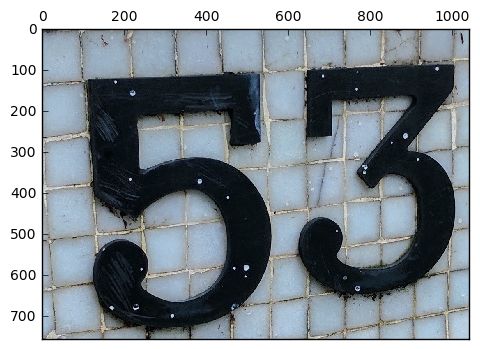

Predicition: [ 8  8 -1 -1 -1]


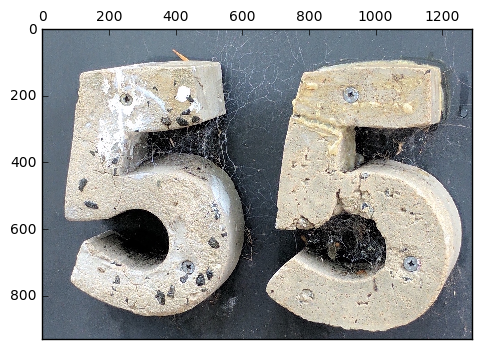

Predicition: [ 5  9 -1 -1 -1]


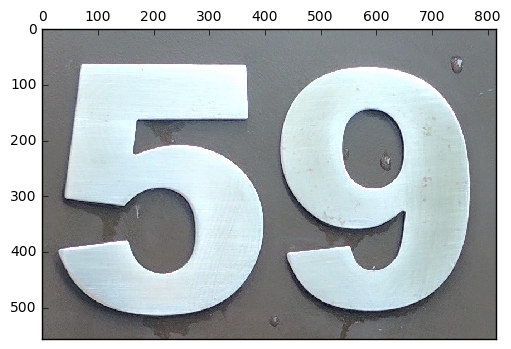

Predicition: [ 8 -1 -1 -1 -1]


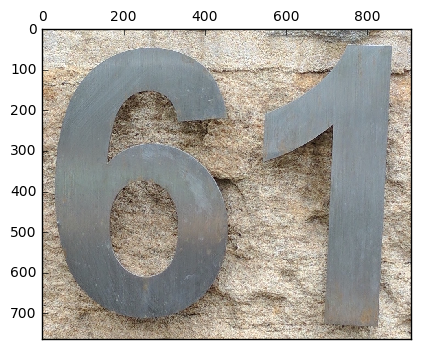

Predicition: [ 3  9 -1 -1 -1]


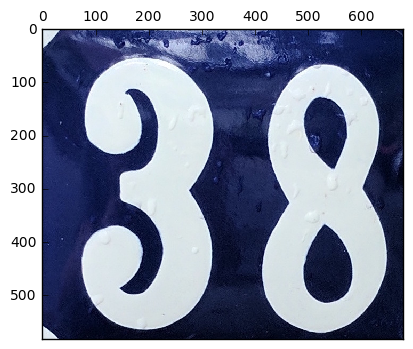

In [92]:
im_files = []
for infile in glob.glob("self/*.jpg"):
    im_files.append(Image.open(infile))

for i, imf in enumerate(im_files):
    print('Predicition:', np.argmax(classification[i], axis = 1) - 1)
    show(imf)

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

It's difficult to see anything obvious that would make classification difficult. Some thoughts might be:

- The grayscale image for the 4th image (61), has very little contrast. This might be particularly difficult to characterise, and it was misclassified as "8".
- The second image (55) was misclassified as "88". This might have something to do with the numbers having a lot of depth (stone) that gives them a 3D perspective.
- For the fifth image, the second digit (8) was misclassfied as 9. This could be because the font is a little unusual and mounted on a warped plate.

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

The model performed OK on these new photos. It got 5 of the 10 digits presented correct. However, it was accurate detecting that there was no digit in positions 3, 4 or 5. These 'no digit' cases included, it correctly classified 20 out of 25 labels, which is 80%. This is comparable to accuracy on the test data.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



We already have a model that will predict the digits in a cropped image.

So a suitable approach will be to train a separate model on uncropped images to find the bounding boxes.

When it comes to final prediction:

1. This new model will predict the bounding region.
2. This region will be used to crop an image and feed into digit recognizer model.

To create this new model, our inputs will also be cropped versions of the original images,however, we'll expand the crop region a bit further. We'll be generating four continuous outputs:

- origin coordinates and opposite corner coordinates.

Like Step 3, it makes sense to convert images to grayscale and resize them.

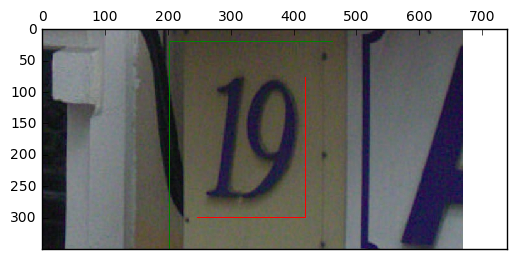

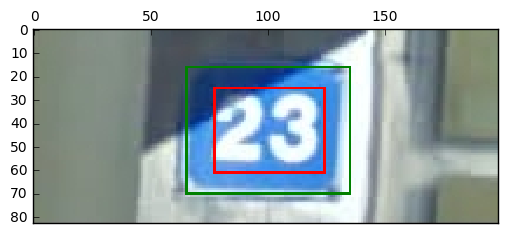

In [14]:
for i in xrange(2):
    original_box = get_box(train_svhn_data[i]['boxes'])
    expanded_box = expand_box(original_box, 0.5)

    im = Image.open('train/' + train_svhn_data[i]['filename'])
    
    draw = ImageDraw.Draw(im)
    draw.rectangle(original_box, outline = 'red')
    draw.rectangle(expanded_box, outline = 'green')
    del draw

    show(im)

Without random cropping...
Boxes: [[7.3813333333333304, 7.4076124567474038, 30.42133333333333, 55.905882352941177], [29.283555555555552, 8.2934256055363313, 56.590222222222216, 56.791695501730104], [-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1]]


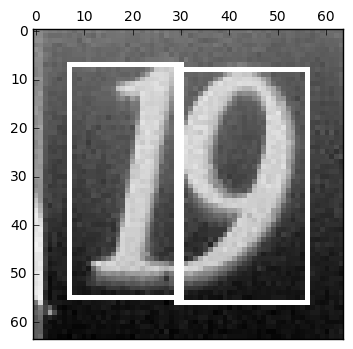

With random cropping...
Box: [[0, 6.4076124567474038, 22.42133333333333, 53.9999], [21.283555555555552, 7.2934256055363313, 48.590222222222216, 53.9999], [-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1]]


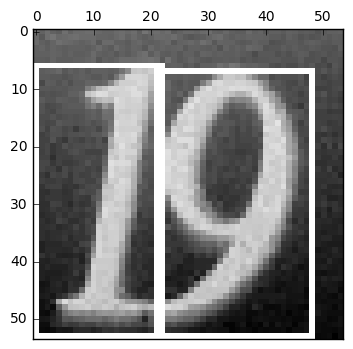

With wrapper function...
Box: [[5.3813333333333304, 0.40761245674740376, 28.42133333333333, 48.905882352941177], [27.283555555555552, 1.2934256055363313, 53.9999, 49.791695501730104], [-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1]]


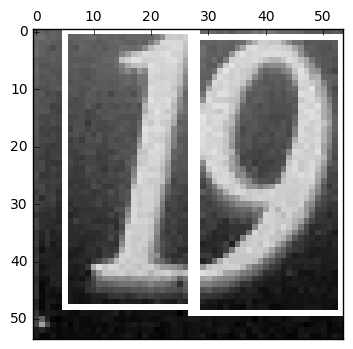

In [17]:
# Extra Helper Functions...

# Get bounding boxes for all digits
# Padded with -1...
def get_boxes(boxes, n_digits = 5):
    bxs = []
    for i in boxes:
        bxs.append([i['left'],
                    i['top'],
                    i['left'] + i['width'],
                    i['top'] + i['height']])
    
    # Pad to n_digits with -1,-1,-1,-1 
    # which will be changed at normalization stage
    if len(bxs) < n_digits:
        for i in xrange(n_digits - len(bxs)):
            bxs.append([-1,-1,-1,-1])
    
    # Return coordinates as x0,y0,x1,y1
    return bxs

# Import an image as grayscale and crop it's expanded box
def crop_large_box(file, boxes, amount = 0.3):
    im = Image.open(file).convert('L')
    original_box = get_box(boxes)
    expanded_box = expand_box(original_box, amount = amount)
    im = im.crop(expanded_box)

    boxes = get_boxes(boxes)
    new_boxes = []
    for i in boxes:
        if i[0] > -1:
            i[0] = i[0] - expanded_box[0]
            i[1] = i[1] - expanded_box[1]
            i[2] = i[2] - expanded_box[0]
            i[3] = i[3] - expanded_box[1]
            
        new_boxes.append(i)

    return im, new_boxes

# Rescale a bounding box coordinates for when image is resized
def scale_box(box, original_size, new_size):
    width_scale = 1.0 * new_size[0] / original_size[0]
    height_scale = 1.0 * new_size[1] / original_size[1]
    box[0] = box[0] * width_scale
    box[1] = box[1] * height_scale
    box[2] = box[2] * width_scale
    box[3] = box[3] * height_scale
    
    # Crop any bounding boxes beyond accetable region
    box[0] = box[0] if 0 <= box[0] <= new_size[0] else 0
    box[1] = box[1] if 0 <= box[1] <= new_size[1] else 0
    box[2] = box[2] if 0 <= box[2] <= new_size[0] else new_size[0]
    box[3] = box[3] if 0 <= box[3] <= new_size[1] else new_size[1]
    
    return box

def convert_for_large_bb(svhn_data, file_directory, new_width = 64, new_height = 64):
    
    infile = os.path.join(file_directory, svhn_data['filename'])
    inbox  = svhn_data['boxes']
    
    im, boxes = crop_large_box(infile, inbox)
    
    original_size = im.size
    
    new_boxes = []
    for i in boxes:
        if i[0] > -1:
            i = scale_box(i, original_size, (new_width, new_height))
        new_boxes.append(i)
    
    im = resize_image(im, new_width, new_height)

    return im, new_boxes

def random_crop_large(img, boxes, crop_width = 54, crop_height = 54):
    width, height = img.size
    
    if (width < crop_width | height < crop_height):
        print('Image dimensions are too small to crop. Returning image.')
        return(img, box)
    
    x_offset = np.random.randint(0, width - crop_width)
    y_offset = np.random.randint(0, height - crop_height)
    
    crop_box = [x_offset, y_offset,
                x_offset + crop_width,
                y_offset + crop_height]
    img = img.crop(crop_box)
    
    bound_boxes = []
    for i in boxes:
        if i[0] > -1:
            i[0] = i[0] - x_offset
            i[1] = i[1] - y_offset
            i[2] = i[2] - x_offset
            i[3] = i[3] - y_offset
            
            # Impose box boundaries if necessary
            i[0] = i[0] if 0 <= i[0] <= crop_width else 0
            i[1] = i[1] if 0 <= i[1] <= crop_height else 0
            i[2] = i[2] if 0 <= i[2] <= crop_width else crop_width - 1e-4
            i[3] = i[3] if 0 <= i[3] <= crop_height else crop_height - 1e-4

        bound_boxes.append(i)

    return img, bound_boxes

# Wrapper function for all
def data_to_thumbnail_large(svhn_data, file_directory):
    img, boxes = convert_for_large_bb(svhn_data, file_directory)
    img, boxes = random_crop_large(img, boxes)
    return(img, boxes)

# Examples
print("Without random cropping...")
img, box = convert_for_large_bb(train_svhn_data[0], train_svnh_folder)
draw = ImageDraw.Draw(img)
for i in box:
    draw.rectangle(i)
print('Boxes:', box)
show(img)

print("With random cropping...")
img, box = random_crop_large(img, box)
draw = ImageDraw.Draw(img)
for i in box:
    draw.rectangle(i)
print('Box:', box)
show(img)

print("With wrapper function...")
img, box = data_to_thumbnail_large(train_svhn_data[0], train_svnh_folder)
draw = ImageDraw.Draw(img)
for i in box:
    draw.rectangle(i)
print('Box:', box)
show(img)

del(img, box)

In [22]:
""" Get all images with resized bounding boxes into numpy arrays """
def create_bounding_arrays(file_directory, svhn_data_list):
    boxes = []
    png = []
    for img_data in svhn_data_list:
        img, box = data_to_thumbnail_large(
            img_data, file_directory)

        if np.any(np.asarray(box) < -1) or np.any(np.asarray(box) > 54.0):
            print(img_data['filename'], 'excluded because it has bounding boxes beyond an acceptable region:\n', box)
        elif len(box) == 5:
            boxes.append(box)
            png.append(np.array(img))
        else:
            print(img_data['filename'], 'excluded because it has an unusual number of digits:', len(box))
        
    return (np.asarray(png), np.asarray(boxes))

train_svhn_full_images, train_svhn_boxes = create_bounding_arrays(train_svnh_folder, train_svhn_data)
test_svhn_full_images,  test_svhn_boxes  = create_bounding_arrays(test_svnh_folder,  test_svhn_data)

print()
print('Training dimensions:', train_svhn_full_images.shape, train_svhn_boxes.shape)
print('Test dimensions:', test_svhn_full_images.shape, test_svhn_boxes.shape)

252.png excluded because it has bounding boxes beyond an acceptable region:
 [[-1.0, 26.0, 15.0, 60.0], [15.219047619047618, 13.462857142857143, 33.504761904761907, 44.548571428571428], [31.980952380952381, 3.4057142857142848, 53.9999, 34.491428571428571], [-1, -1, -1, -1], [-1, -1, -1, -1]]
724.png excluded because it has bounding boxes beyond an acceptable region:
 [[-1.0, 57.0, 43.0, 165.0], [22.178761061946901, 3.673103448275862, 47.665486725663712, 51.342068965517242], [-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1]]
5312.png excluded because it has bounding boxes beyond an acceptable region:
 [[-1.0, 20.0, 6.0, 60.0], [11.230769230769234, 0, 32.153846153846153, 42.420689655172417], [29.692307692307693, 0, 50.61538461538462, 43.524137931034481], [-1, -1, -1, -1], [-1, -1, -1, -1]]
6877.png excluded because it has bounding boxes beyond an acceptable region:
 [[-1.0, 28.0, 31.0, 97.0], [-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1], [-1, -1, -1, -1]]
18277.png excluded be

In [23]:
# Normalizing data...  FOR BOUNDING BOXES TOO!
pixel_max = float(train_svhn_full_images.max())
image_size_max = 54

print("Original pixel min and max:", train_svhn_full_images.min(), train_svhn_full_images.max())
print("Original bounding box min and max:", train_svhn_boxes.min(), train_svhn_boxes.max())

train_svhn_full_images = train_svhn_full_images / pixel_max
test_svhn_full_images  = test_svhn_full_images  / pixel_max
train_svhn_boxes[train_svhn_boxes > -1] = train_svhn_boxes[train_svhn_boxes > -1] / image_size_max
test_svhn_boxes[test_svhn_boxes > -1]   = test_svhn_boxes[test_svhn_boxes > -1] / image_size_max

# Check images are still legit:
print("New pixel min and max:", train_svhn_full_images.min(), train_svhn_full_images.max())
print("New bounding box min and max:", train_svhn_boxes.min(), train_svhn_boxes.max())

Original pixel min and max: 0 255
Original bounding box min and max: -1.0 54.0
New pixel min and max: 0.0 1.0
New bounding box min and max: -1.0 1.0


In [24]:
# Now we'll convert no digit boxes (coded -1) as a tiny box in corner
for i in xrange(train_svhn_boxes.shape[0]):
    for j in xrange(train_svhn_boxes[i].shape[0]):
        if train_svhn_boxes[i,j,0] == -1:
            train_svhn_boxes[i, j] = [0.0, 0.0, 1e-3, 1e-3]
            
for i in xrange(test_svhn_boxes.shape[0]):
    for j in xrange(test_svhn_boxes[i].shape[0]):
        if test_svhn_boxes[i,j,0] == -1:
            test_svhn_boxes[i, j] = [0.0, 0.0, 1e-3, 1e-3]
            
print("New bounding box min and max:", train_svhn_boxes.min(), train_svhn_boxes.max())

New bounding box min and max: 0.0 1.0


Convert image data to correct format and split test data into validation and test:

In [25]:
p_valid = 0.4    # Proportion of test set to be used for validation set

def format_full_images(dataset, num_channels = 1):
    shp = dataset.shape
    dataset = dataset.reshape(
        (-1, shp[1], shp[2], num_channels)).astype(np.float32)
    return dataset

n_valid = int(test_svhn_full_images.shape[0] * p_valid)

train_svhn_full, train_svhn_boxes_l = format_full_images(train_svhn_full_images), train_svhn_boxes
valid_svhn_full, valid_svhn_boxes_l = format_full_images(test_svhn_full_images[:n_valid]), test_svhn_boxes[:n_valid]
test_svhn_full, test_svhn_boxes_l   = format_full_images(test_svhn_full_images[n_valid:]), test_svhn_boxes[n_valid:]

print('Training set', train_svhn_full.shape, train_svhn_boxes_l.shape)
print('Validation set', valid_svhn_full.shape, valid_svhn_boxes_l.shape)
print('Test set', test_svhn_full.shape, test_svhn_boxes_l.shape)

Training set (33385, 54, 54, 1) (33385, 5, 4)
Validation set (5225, 54, 54, 1) (5225, 5, 4)
Test set (7839, 54, 54, 1) (7839, 5, 4)


Training image 0


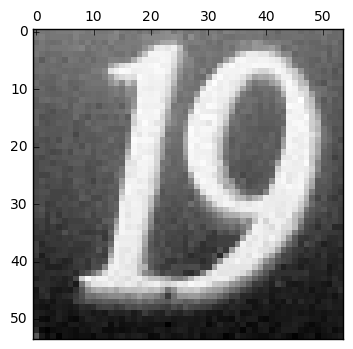

[[ 0.06261728  0.04458542  0.48928395  0.94270153]
 [ 0.46821399  0.06098936  0.973893    0.95910547]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  3.38133333   2.40761246  26.42133333  50.90588235]
 [ 25.28355556   3.29342561  52.59022222  51.7916955 ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Validation image 0


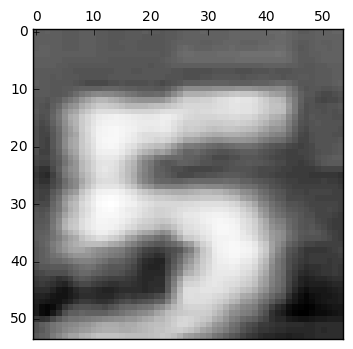

[[ 0.06103704  0.11823362  0.96177778  0.99999815]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  3.296        6.38461538  51.936       53.9999    ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Test image 0


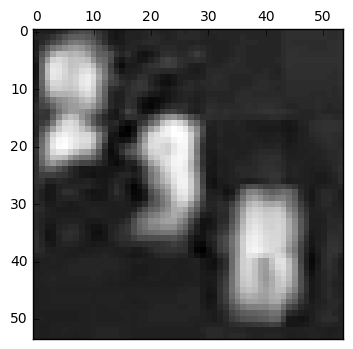

[[ 0.          0.00680448  0.29299299  0.44780362]
 [ 0.29299299  0.25486649  0.58128128  0.69586563]
 [ 0.58128128  0.47536606  0.9016016   0.9163652 ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  0.           0.36744186  15.82162162  24.18139535]
 [ 15.82162162  13.7627907   31.38918919  37.57674419]
 [ 31.38918919  25.66976744  48.68648649  49.48372093]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Training image 1


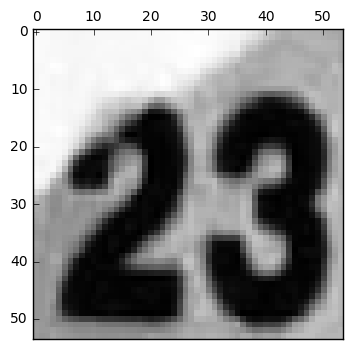

[[ 0.08142077  0.24219002  0.52829387  0.99999815]
 [ 0.48943534  0.13913043  0.99459624  0.96360709]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  4.39672131  13.07826087  28.52786885  53.9999    ]
 [ 26.4295082    7.51304348  53.70819672  52.03478261]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Validation image 1


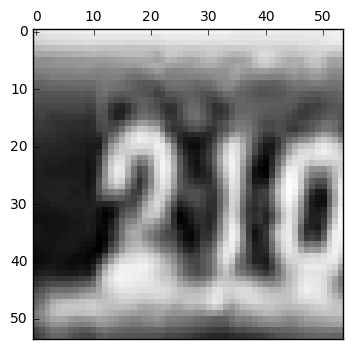

[[ 0.11885522  0.09891068  0.4959596   0.90065359]
 [ 0.52289562  0.20348584  0.73838384  0.99999815]
 [ 0.71144781  0.13376906  0.99999815  0.93551198]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  6.41818182   5.34117647  26.78181818  48.63529412]
 [ 28.23636364  10.98823529  39.87272727  53.9999    ]
 [ 38.41818182   7.22352941  53.9999      50.51764706]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Test image 1


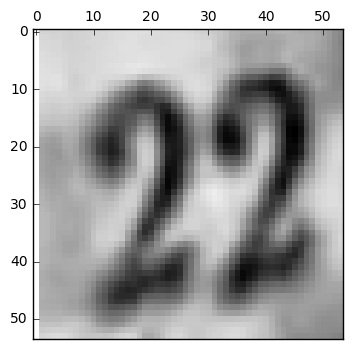

[[ 0.13675214  0.11544974  0.59259259  0.99587302]
 [ 0.53181387  0.0815873   0.99999815  0.96201058]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  7.38461538   6.23428571  32.          53.77714286]
 [ 28.71794872   4.40571429  53.9999      51.94857143]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Training image 2


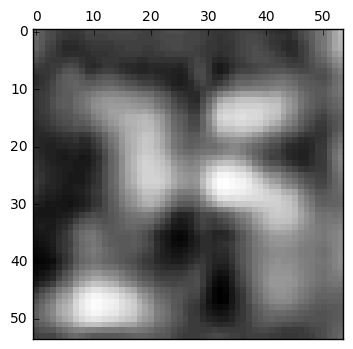

[[ 0.02028986  0.12183236  0.43252818  0.99999815]
 [ 0.43252818  0.12183236  0.8962963   0.99999815]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  1.09565217   6.57894737  23.35652174  53.9999    ]
 [ 23.35652174   6.57894737  48.4         53.9999    ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Validation image 2


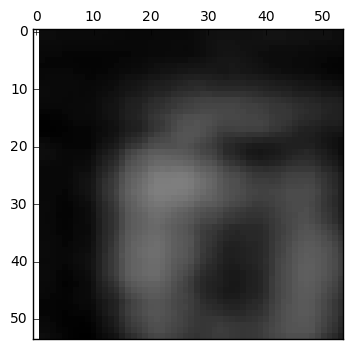

[[ 0.13037037  0.14222222  0.99950617  0.99999815]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  7.04         7.68        53.97333333  53.9999    ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Test image 2


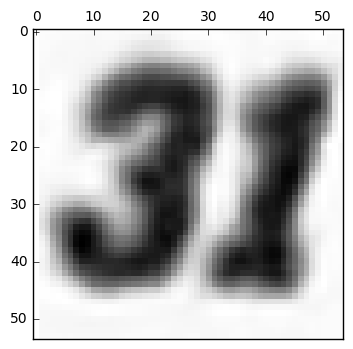

[[ 0.13933934  0.          0.55575576  0.87901235]
 [ 0.58778779  0.02304527  0.99999815  0.91193416]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  7.52432432   0.          30.01081081  47.46666667]
 [ 31.74054054   1.24444444  53.9999      49.24444444]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Training image 3


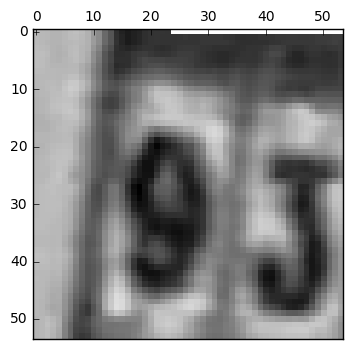

[[ 0.1382716   0.13737374  0.63209877  0.99999815]
 [ 0.63209877  0.13737374  0.99999815  0.99999815]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  7.46666667   7.41818182  34.13333333  53.9999    ]
 [ 34.13333333   7.41818182  53.9999      53.9999    ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Validation image 3


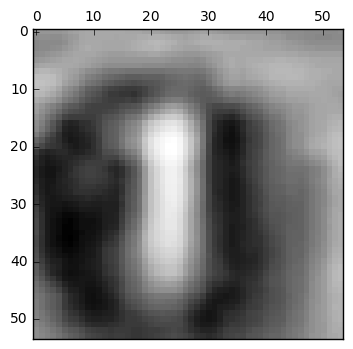

[[ 0.          0.07584541  0.91193416  0.95185185]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  0.           4.09565217  49.24444444  51.4       ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]

Test image 3


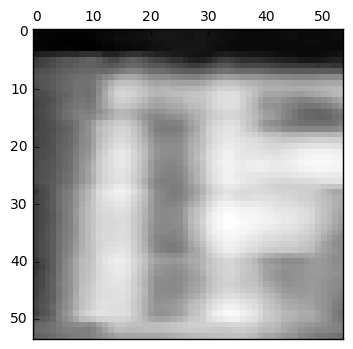

[[ 0.1237037   0.1003367   0.65703704  0.96228956]
 [ 0.53851852  0.15420875  0.99999815  0.99999815]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]
 [ 0.          0.          0.001       0.001     ]]
[[  6.68         5.41818182  35.48        51.96363636]
 [ 29.08         8.32727273  53.9999      53.9999    ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]
 [  0.           0.           0.054        0.054     ]]



In [26]:
# Checking coding
for i in xrange(4):
    print("Training image", i)
    show(np.squeeze(train_svhn_full, axis=(3,))[i])
    print(train_svhn_boxes_l[i])
    print(train_svhn_boxes_l[i]*54)
    print()
    print("Validation image", i)
    show(np.squeeze(valid_svhn_full, axis=(3,))[i])
    print(valid_svhn_boxes_l[i])
    print(valid_svhn_boxes_l[i]*54)
    print()
    print("Test image", i)
    show(np.squeeze(test_svhn_full, axis=(3,))[i])
    print(test_svhn_boxes_l[i])
    print(test_svhn_boxes_l[i]*54)
    print()

## We're now ready to begin modelling!

We'll use a very similar model as before, except that we'll be using regression to predict the bounding box coordinates rather than discrete digit values.

In [125]:
def batch_iou(a, b, epsilon=1e-5):
    """ 
        IoU from: http://ronny.rest/tutorials/lesson/intersect_of_union/
        
        Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers:
            [x1,y1,x2,y2]
        where:
            x1,y1 represent the upper left corner
            x2,y2 represent the lower right corner
        It returns the Intersect of Union scores for each corresponding
        pair of boxes.

    Args:
        a:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        b:          (numpy array) each row containing [x1,y1,x2,y2] coordinates
        epsilon:    (float) Small value to prevent division by zero

    Returns:
        (numpy array) The Intersect of Union scores for each pair of bounding
        boxes.
    """
    # COORDINATES OF THE INTERSECTION BOXES
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)
    
    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)
    return iou


# NOTE - as is, doesn't deal well with 'missing' digits, but gets the point across
def multi_batch_iou_mean(a, b, epsilon=1e-8):
    ious = []
    for i, j in zip(a, b):
        batch_ious = batch_iou(np.array(i), np.array(j), epsilon=epsilon)
        ious.append(np.mean(batch_ious))
    return np.mean(ious)

In [65]:
batch_size = 128
patch_size = 5
img_size = train_svhn_full.shape[1:3]
num_channels = 1
num_coords = train_svhn_boxes_l.shape[2]
num_digits = train_svhn_boxes_l.shape[1]
beta = 1.0

# Conv depths...
depth1 = 16
depth2 = 32
depth3 = 64
depth4 = 128

# Hidden layers...
n_hidden1 = 128
n_hidden2 = 3072
n_hidden3 = 3072
    
# Input data -----------------------
tf_train = tf.placeholder(
    tf.float32, shape = (batch_size, img_size[0], img_size[1], num_channels)
)
tf_train_l = tf.placeholder(
    tf.float32, shape = (batch_size, num_digits, num_coords)
)
tf_valid = tf.constant(valid_svhn_full)
tf_test  = tf.constant(test_svhn_full)

# Net parameters -----------------------

# Wrapper functions for weights and biases of
# convulations, fully connected, and linear predictor layers
def conv_w_and_b(input, output):
    w = tf.Variable(
        tf.truncated_normal([patch_size, patch_size, input, output], stddev = 0.05)
    )
    b = tf.Variable(
        tf.zeros([output])
    )
    return w,b

def fully_w_and_b(input, output):
    w = tf.Variable(
        tf.truncated_normal([input, output], stddev = 0.05)
    )
    b = tf.constant(1.0, shape = [output])

    return w,b

def linear_w_and_b(input, output):
    w = tf.Variable(
        tf.truncated_normal([input, output], stddev = 0.05)
    )
    b = tf.constant(1.0, shape = [output])

    return w,b

# Convolution layers
c1_w, c1_b = conv_w_and_b(num_channels, depth1)
c2_w, c2_b = conv_w_and_b(depth1, depth2)
c3_w, c3_b = conv_w_and_b(depth2, depth3)
c4_w, c4_b = conv_w_and_b(depth3, depth4)

# Fully connected layers 
f1_w, f1_b = fully_w_and_b(depth4, n_hidden1)
f2_w, f2_b = fully_w_and_b(n_hidden1, n_hidden2)
f3_w, f3_b = fully_w_and_b(n_hidden2, n_hidden3)

# Linear predictor
#s1_w, s1_b = linear_w_and_b(n_hidden3, num_coords)
s1_w, s1_b = linear_w_and_b(n_hidden3, num_coords)
s2_w, s2_b = linear_w_and_b(n_hidden3, num_coords)
s3_w, s3_b = linear_w_and_b(n_hidden3, num_coords)
s4_w, s4_b = linear_w_and_b(n_hidden3, num_coords)
s5_w, s5_b = linear_w_and_b(n_hidden3, num_coords)

# Model ----------------------

# Convolution wrapper
def conv2d(X, W, b):
    conv = tf.nn.conv2d(X, W, strides = [1, 2, 2, 1], padding = 'SAME') + b
    # Order (1) pool then (2) hidden reduces computation requirements and speeds learning
    pool = tf.nn.max_pool(conv, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    hidden = tf.nn.relu(pool)
    return hidden

# Model
def model(data, keep_prob = 1):
    # Convolution layers
    x = conv2d(data, c1_w, c1_b)
    x = conv2d(x,    c2_w, c2_b)
    x = conv2d(x,    c3_w, c3_b)
    x = conv2d(x,    c4_w, c4_b)

    # Fully connected
    shape = x.get_shape().as_list()
    reshape = tf.reshape(x, [shape[0], shape[1] * shape[2] * shape[3]])
    x = tf.nn.relu(tf.matmul(reshape, f1_w) + f1_b)
    x = tf.nn.relu(tf.matmul(x, f2_w) + f2_b)
    x = tf.nn.relu(tf.matmul(x, f3_w) + f3_b)
    x = tf.nn.dropout(x, keep_prob)

    # Linear regression
    #pred = tf.matmul(x, s1_w) + s1_b
    lin1 = tf.matmul(x, s1_w) + s1_b
    lin2 = tf.matmul(x, s2_w) + s2_b
    lin3 = tf.matmul(x, s3_w) + s3_b
    lin4 = tf.matmul(x, s4_w) + s4_b
    lin5 = tf.matmul(x, s5_w) + s5_b
    pred = tf.pack((lin1, lin2, lin3, lin4, lin5), axis = 1)

    print(pred)
    return(pred)

# Run --------------------------
pred_boxes = model(tf_train, 0.50)
loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(tf_train_l, pred_boxes)))) # RMSE

# Adam optimizer (has a self adjusting learning rate)
optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)

train_pred = pred_boxes
valid_pred = model(tf_valid)
test_pred  = model(tf_test)

Tensor("pack_8:0", shape=(128, 5, 4), dtype=float32)
Tensor("pack_9:0", shape=(5225, 5, 4), dtype=float32)
Tensor("pack_10:0", shape=(7839, 5, 4), dtype=float32)


In [108]:
""" Run the graph """
num_steps = 200001 # 200001
start_time = time.time()
saver_directory = 'tf_box_saver'
if not os.path.exists(saver_directory):
    os.makedirs(saver_directory)

session = tf.Session()
session.run(tf.global_variables_initializer())
print("Intialized\n")

# Create a saver.
saver = tf.train.Saver()

for step in range(num_steps):
    offset  = (step * batch_size) % (train_svhn_boxes_l.shape[0] - batch_size)
    batch   = train_svhn_full[offset:(offset + batch_size), :, :, :]
    batch_l = train_svhn_boxes_l[offset:(offset + batch_size), :]
    feed_dict = {
        tf_train   : batch,
        tf_train_l : batch_l
    }
    _, l, predictions = session.run(
        [optimizer, loss, train_pred], feed_dict = feed_dict
    )

    if (step % 1000 == 0):
        print('--- Step %d ---' % (step))
        print('Time elapsed: %.1f seconds' % (time.time() - start_time))
        print('Minibatch loss: %f' % (l))
        print('Minibatch mean IoU: %.3f' % multi_batch_iou_mean(predictions, batch_l))
        print('Validation mean IoU: %.3f' % multi_batch_iou_mean(valid_pred.eval(session = session), valid_svhn_boxes_l))
        print()

# Save the model
saver.save(session, saver_directory + '/model')

print('--- Test ---')
print('Test mean IoU: %.3f' % multi_batch_iou_mean(test_pred.eval(session = session), test_svhn_boxes_l))

Intialized

--- Step 0 ---
Time elapsed: 5.8 seconds
Minibatch loss: 10.614057
Minibatch mean IoU: 0.000
Validation mean IoU: 0.000

--- Step 1000 ---
Time elapsed: 292.6 seconds
Minibatch loss: 0.231642
Minibatch mean IoU: 0.134
Validation mean IoU: 0.149

--- Step 2000 ---
Time elapsed: 579.3 seconds
Minibatch loss: 0.205318
Minibatch mean IoU: 0.150
Validation mean IoU: 0.166

--- Step 3000 ---
Time elapsed: 864.8 seconds
Minibatch loss: 0.201182
Minibatch mean IoU: 0.166
Validation mean IoU: 0.186

--- Step 4000 ---
Time elapsed: 1150.6 seconds
Minibatch loss: 0.211377
Minibatch mean IoU: 0.171
Validation mean IoU: 0.201

--- Step 5000 ---
Time elapsed: 1436.5 seconds
Minibatch loss: 0.200188
Minibatch mean IoU: 0.178
Validation mean IoU: 0.213

--- Step 6000 ---
Time elapsed: 1722.4 seconds
Minibatch loss: 0.181550
Minibatch mean IoU: 0.178
Validation mean IoU: 0.217

--- Step 7000 ---
Time elapsed: 2007.9 seconds
Minibatch loss: 0.205021
Minibatch mean IoU: 0.188
Validation mean 

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

The final Intersection over Union (IoU) of the bounding boxes on the test data set was .294 (29.4%). This is pretty good for a few reasons. First, the no-digit bounding boxes are tiny, and typically lead to zero result here. Approximately 60-70% of the data involves no digits. Therefore, a threshold value for maximising IoU will be around 30-40%. The final result of this model achieved the lower bound of this, which is therefore a reasonably good result.

To demonstrate, the model is used on new data for the following question, and show reasonable localization.

Regarding the classificaiton results, this will not directly change the result here. However, it would be possible to use these results to generate a complete counding box, crop an image, and then feed it to the DNN used for classification in earlier steps. This would like help to improve model performance.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**
    
Below I've used the model created above to generate bounding boxes for the images I captured in Step 3. The final results show that the model accurately generates 2 bounding boxes for each image, and positions them with reasonable precision.

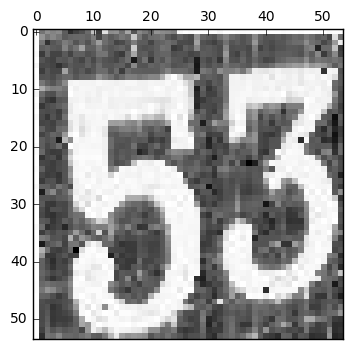

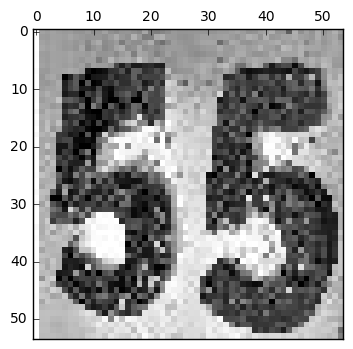

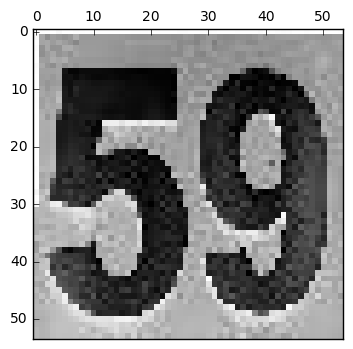

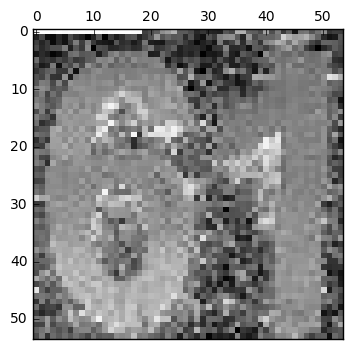

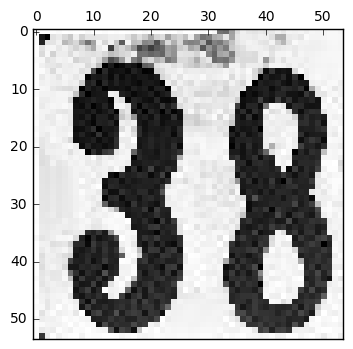

In [109]:
# Show the images created in Step 3.
for infile in glob.glob("self/*.thumbnail"):
    show(Image.open(infile))

In [110]:
# Using these images as created earlier, check their dimensions and pixel range
print('Shape:', self_images.shape)
print('Pixel range:', self_images.min(), self_images.max())

Shape: (5, 54, 54, 1)
Pixel range: 0.0 1.0


In [111]:
# Generate a prediction using the model for each image
tf_self = tf.constant(self_images)
self_pred = model(tf_self)
results = self_pred.eval(session = session)

Tensor("pack_16:0", shape=(5, 5, 4), dtype=float32)


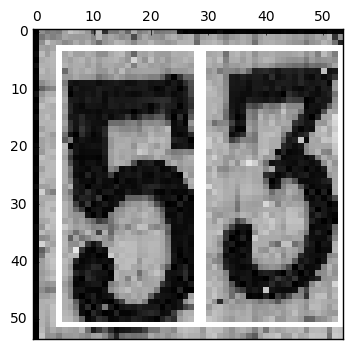

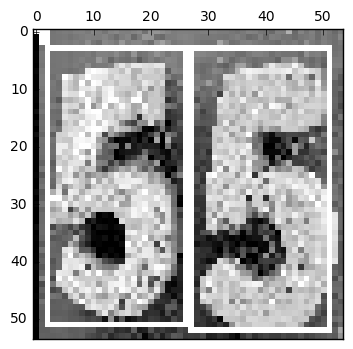

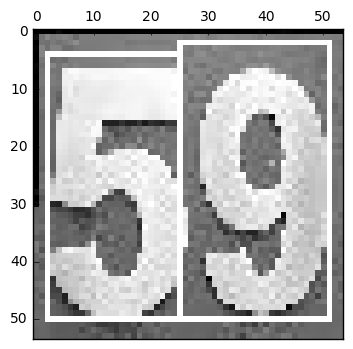

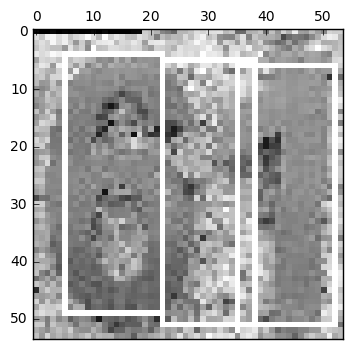

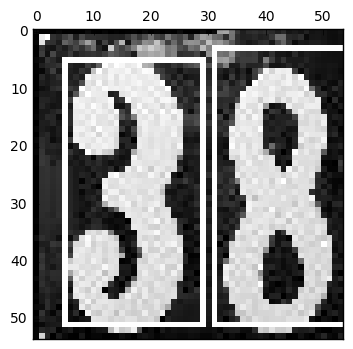

In [113]:
# Draw the results
for i, imf in enumerate(self_images):
    img = Image.fromarray(np.squeeze(imf, axis=(2,)) * 255)
    draw = ImageDraw.Draw(img)
    for b in results[i]:
        draw.rectangle(b * 54, outline = "white")
    show(img)

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.